# TODO: Angle aerofoils 

[1.8, 1.5]
area =  2.7


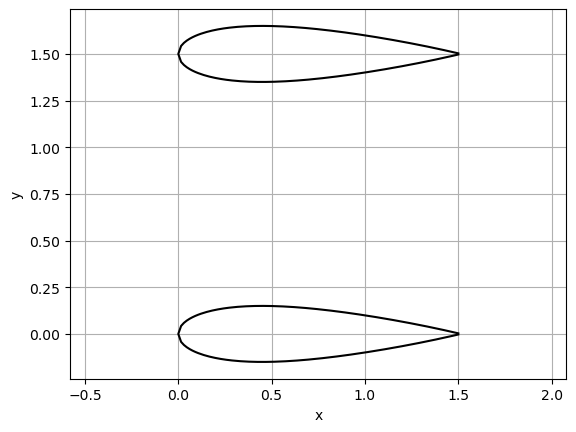

In [8]:
from aerofoil2 import *
from aerofoil import naca_foil, custom_foil, naca_one_side
from matplotlib import pyplot as plt

# size limit = 1.54 x 1.51m as its Hilux 

foil_width = 0.3
turbine_width = 1.2 + foil_width

turbine_length = 1.5
t_c = 0.2
alphas = [0,0]
# alphas = [10,-10]

# Create a custom aerofoil
# x,y = custom_foil(foil_width, t_c,alpha=alphas[0], side='left')
# x2,y2 = custom_foil(foil_width, t_c,alpha=alphas[1], side='right')

# Create a NACA 0012 aerofoil
x,y = naca_foil(foil_width, alpha=alphas[0])
x2,y2 = naca_foil(foil_width, alpha=alphas[1])

# NB: to create a nozzle use any of the above functions and set the foil width to 0.01

# create an asym foil
# x,y = naca_one_side(foil_width,side='left', alpha=alphas[0])
# x2,y2 = naca_one_side(foil_width,side='right', alpha = alphas[1])
tru_size = [turbine_width + foil_width, turbine_length]
print(tru_size)
print('area = ', tru_size[0]*tru_size[1])
# scale the aerofoil length
x = x * turbine_length
x2 = x2 * turbine_length

# Plot the aerofoil
plt.plot(x,y,'k-')
plt.plot(x2,y2 + turbine_width,'k-')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()



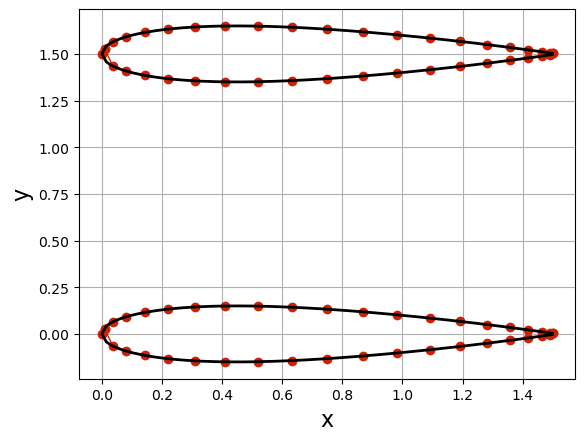

In [2]:
import numpy as np

plt.figure()
aerofoils = np.empty(2, dtype=object)
# aerofoils = np.empty(1, dtype=object)
coords = [[x,y],[x2,y2]]
# coords = [[x,y]]
# discretise the aerofoil into panels
for i,aerofoil in enumerate(coords):
    aerofoils[i] = define_panels(aerofoil[0],aerofoil[1],N=40,dir=i) # flip the direction in which the panels generated!

# now move the aerofoils to the correct position
for panel in aerofoils[1]:
    panel.ya = panel.ya + turbine_width
    panel.yb = panel.yb + turbine_width
    panel.yc = panel.yc + turbine_width
y2 = y2 + turbine_width


# plot the panels
for i,aerofoil in enumerate(aerofoils):
    plt.plot(np.append([panel.xa for panel in aerofoil], aerofoil[0].xa),
            np.append([panel.ya for panel in aerofoil], aerofoil[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')

plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(x2, y2, color='k', linestyle='-', linewidth=2)




In [3]:
# define the freestream conditions
u_inf = 1.15
alpha = 0
freestream = Freestream(u_inf, alpha)


In [4]:
### WHY IS EFFECT OF ONE AEROFOIL NOT VISIBLE?

for i,p in enumerate(aerofoils):  
    A_source = source_contribution_normal(p)
    B_vortex = vortex_contribution_normal(p)

    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(p, freestream)

    # solve for singularity strengths
    strengths = numpy.linalg.solve(A, b)

    # store source strength on each panel
    for i , panel in enumerate(p):
        panel.sigma = strengths[i]
        
    # store circulation density
    gamma = strengths[-1]
    # tangential velocity at each panel center.
    compute_tangential_velocity(p, freestream, gamma, A_source, B_vortex)
    # surface pressure coefficient
    compute_pressure_coefficient(p, freestream)

/Users/philblecher/Desktop/Github/DP5-code/aerofoil2.py:288: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(integrand, 0.0, panel.length)[0]


Text(0.04999999999999999, 0.75, '1.226')

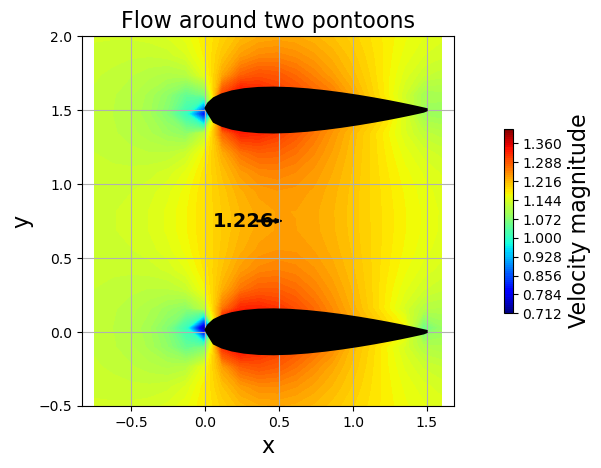

In [5]:
# define velocity field
nx, ny = 20, 20
x_start, x_end = -turbine_length/2, turbine_length + 0.1
y_start, y_end = - 0.2 - foil_width, turbine_width + foil_width + 0.2
x_ = np.linspace(x_start, x_end, nx)
y_ = np.linspace(y_start, y_end, ny)
X, Y = np.meshgrid(x_, y_)

plt.figure()
plt.axis('equal')
# compute the velocity field on the mesh grid
u_tot = np.zeros((ny, nx))
v_tot = np.zeros((ny, nx))


u1, v1 = vel_field(aerofoils[0], freestream, X, Y)
u2, v2 = vel_field(aerofoils[1], freestream, X, Y)

u_tot = u2 + u1 
v_tot = v2  + v1
u_tot = u_tot / 2
v_tot = v_tot / 2

# # plot the velocity field  
# plt.streamplot(X, Y, u_tot, v_tot, density=2, linewidth=1, arrowsize=1, arrowstyle='->')

for panels in aerofoils:
    plt.fill([panel.xc for panel in panels],
        [panel.yc for panel in panels],
        color='k', linestyle='solid', linewidth=2, zorder=2)
    
# add contours of velocity
plt.contourf(X, Y, np.sqrt(u_tot**2 + v_tot**2), cmap='jet', levels=100)
cbar = plt.colorbar(orientation='vertical', shrink=0.5, pad=0.1)
cbar.set_label('Velocity magnitude', fontsize=16)

plt.grid()
plt.title('Flow around two pontoons', fontsize=16)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)

# calculate velocity at x = 0.5, y = width/2
x_point = 0.35
y_point = turbine_width/2

up_tot=0
vp_tot=0
for i,panels in enumerate(aerofoils):
    u, v = vel_field(panels, freestream, x_point, y_point)
    up_tot += u
    vp_tot += v
# normalize the velocity field
up_tot /= 2
vp_tot /= 2

# put an arrow there
plt.arrow(x_point, y_point, up_tot/10, vp_tot/10, width=0.01, color='k')

# find the net velocity at this point
vel = np.sqrt(up_tot**2 + vp_tot**2)
plt.text(x_point-0.3, y_point, '%.3f' %vel, fontsize=14, fontweight='bold', va='center')



Power output with pontoons....

Missing variables: P, A
Power output without pontoons....

Missing variables: P, A


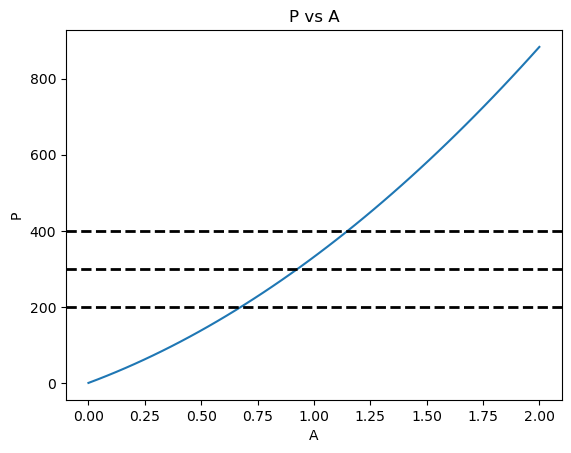

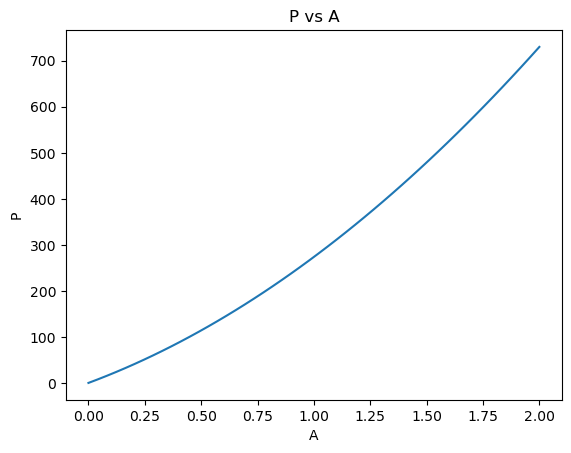

In [7]:
from power_calcs import *

# calculate the power output of the turbine at this point
rho = 1000
efficiency = 0.3 # Efficiency to be confirmed 
# power = 400
area = 0.7

print("Power output with pontoons....")
power1,_,_,_,_ = power_calc(efficiency=efficiency, V=vel)
# draw horizontal line at this power
plt.axhline(400, color='k', linestyle='--', linewidth=2)
plt.axhline(300, color='k', linestyle='--', linewidth=2)
plt.axhline(200, color='k', linestyle='--', linewidth=2)
print("Power output without pontoons....")
power2,_,_,_,_ = power_calc(efficiency=efficiency, V=u_inf)
